In [199]:
import cv2
import matplotlib.pyplot as plt
import numpy
import os
import json
import pandas as pd

from PIL import Image
from patchify import patchify #split image
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras.utils import to_categorical

from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

import json



%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras


In [200]:
image = cv2.imread('Semantic segmentation dataset\Tile 1\images\image_part_001.jpg')
mask= cv2.imread("Semantic segmentation dataset\Tile 1\masks\image_part_001.png")

In [201]:
label = open('Semantic segmentation dataset\classes.json')
label = json.load(label)

In [202]:
directory = 'Semantic segmentation dataset'
size_image= 256
scaler= MinMaxScaler()

In [203]:
image_dataset = []
for path, subdir, files in os.walk(directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(images):
            if image_name.endswith('.jpg'):
                image = cv2.imread(path+"/"+image_name,1)
                size_x =(image.shape[1]//size_image)*size_image
                size_y =(image.shape[0]//size_image)*size_image
                image = Image.fromarray(image)
                image = image.crop((0,0, size_x, size_y))
                image = np.array(image)
                print("path: ",path+"/"+image_name)
                patches_img = patchify(image,(size_image, size_image,3), step = size_image) #step 256 means no overlaps
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)


path:  Semantic segmentation dataset\Tile 1\images/image_part_001.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_002.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_003.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_004.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_005.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_006.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_007.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_008.jpg
path:  Semantic segmentation dataset\Tile 1\images/image_part_009.jpg
path:  Semantic segmentation dataset\Tile 2\images/image_part_001.jpg
path:  Semantic segmentation dataset\Tile 2\images/image_part_002.jpg
path:  Semantic segmentation dataset\Tile 2\images/image_part_003.jpg
path:  Semantic segmentation dataset\Tile 2\images/image_part_004.jpg
path:  Semantic segmentation dataset\Tile 2\images/image_part_005.jpg
path:  Semantic segm

In [204]:
mask_dataset = []
for path, subdir, files in os.walk(directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        for i, mask_name in enumerate(masks):
            if mask_name.endswith('.png'):
                mask = cv2.imread(path+"/"+mask_name,1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                size_x =(mask.shape[1]//size_image)*size_image
                size_y =(mask.shape[0]//size_image)*size_image
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0, size_x, size_y))
                mask = np.array(mask)

                print("path: ",path+"/"+mask_name)
                patches_mask = patchify(mask,(size_image, size_image,3), step = size_image) #step 256 means no overlaps
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        # single_patch_mask = scaler.fit_transform(single_patch_mask.reshape(-1, single_patch_mask.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_mask = single_patch_mask[0]
                        mask_dataset.append(single_patch_mask)


path:  Semantic segmentation dataset\Tile 1\masks/image_part_001.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_002.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_003.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_004.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_005.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_006.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_007.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_008.png
path:  Semantic segmentation dataset\Tile 1\masks/image_part_009.png
path:  Semantic segmentation dataset\Tile 2\masks/image_part_001.png
path:  Semantic segmentation dataset\Tile 2\masks/image_part_002.png
path:  Semantic segmentation dataset\Tile 2\masks/image_part_003.png
path:  Semantic segmentation dataset\Tile 2\masks/image_part_004.png
path:  Semantic segmentation dataset\Tile 2\masks/image_part_005.png
path:  Semantic segmentation datas

In [206]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [207]:
int('3C', 16)
building = '#3C1098'.lstrip('#')
building = np.array(tuple(int(building[i:i+2],16) for i in(0,2,4)))

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


In [208]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


In [209]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [210]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [211]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [212]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)
IMG_HEIGHT = X_train.shape[1]
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


metrics=['accuracy', jacard_coef]

In [213]:
import tensorflow as tf
from keras.models import load_model
from keras.metrics import MeanIoU

name = 'models/satellite_standard_unet_100epochs_18May2024.hdf5'
model = load_model(name,
                   custom_objects={'dice_loss_plus_2focal_loss': 'categorical_crossentropy',
                                   'jacard_coef': jacard_coef})

# Predict the labels for the test data
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Using built-in Keras function for IoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
iou_score = IOU_keras.result().numpy()


# Evaluate the model on the test data
metrics = model.evaluate(X_test, y_test, verbose=1)
loss = metrics[0]
accuracy = metrics[1]

# Calculate F1 score and recall
precision = Precision()
precision.update_state(y_test_argmax.flatten(), y_pred_argmax.flatten())
precision_result = precision.result().numpy()

recall = Recall()
recall.update_state(y_test_argmax.flatten(), y_pred_argmax.flatten())
recall_result = recall.result().numpy()

f1_score = 2 * (precision_result * recall_result) / (precision_result + recall_result)

print("Mean IoU =", iou_score)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Recall:", recall_result)


9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8640 - jacard_coef: 0.7217 - loss: 0.5280
Mean IoU = 0.5978927
Loss: 0.5290303826332092
Accuracy: 0.8592885136604309
F1 Score: 0.9707892044874162
Recall: 0.9842246


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


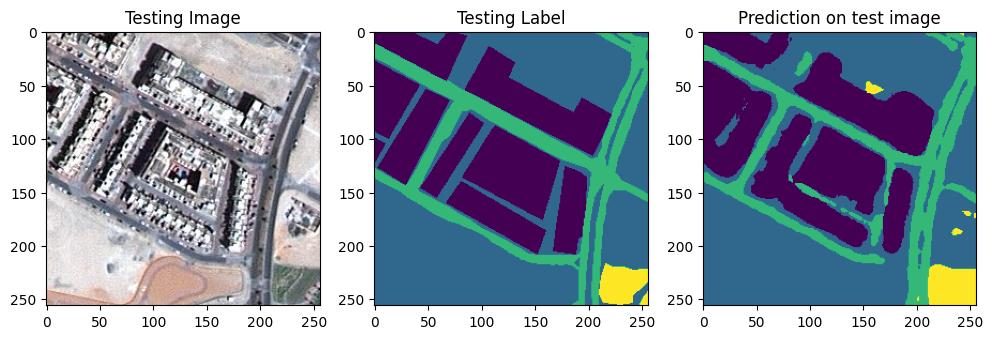

In [214]:

import random
# test_img_number = random.randint(0, len(X_test)) #109
test_img_number = 200

test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [218]:
import pandas as pd
import matplotlib.pyplot as plt

In [219]:
history_training = pd.read_csv(r'D:\belajar\final project\history_training.csv')

In [220]:
history_training

Unnamed: 0  accuracy  jacard_coef      loss  val_accuracy  \
0            0  0.549826     0.291389  1.188205      0.643592   
1            1  0.646212     0.382494  0.950255      0.685513   
2            2  0.687385     0.431420  0.841098      0.728277   
3            3  0.712273     0.449147  0.796574      0.754262   
4            4  0.738461     0.470798  0.753487      0.760697   
..         ...       ...          ...       ...           ...   
95          95  0.884908     0.712929  0.334905      0.850841   
96          96  0.907617     0.765091  0.260676      0.854793   
97          97  0.914493     0.780020  0.240495      0.859420   
98          98  0.918524     0.791050  0.225069      0.856268   
99          99  0.921618     0.797693  0.215709      0.859289   

    val_jacard_coef  val_loss  
0          0.344297  1.030212  
1          0.430596  0.827928  
2          0.447494  0.764965  
3          0.451961  0.719274  
4          0.475260  0.690416  
..              ...       ...  
95         0.670918  0.480954  
96         0.695961  0.510638  
97         0.705778  0.500720  
98         0.701509  0.510067  
99         0.709346  0.529030  

[100 rows x 7 columns]

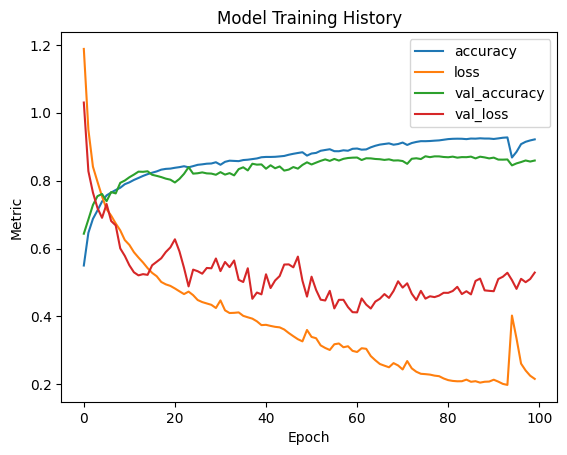

In [221]:
history_training[['accuracy','loss','val_accuracy','val_loss']].plot()
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

Dilihat dari graphic, accurcay training dan accuracy validation dari epoch 20 sampai ecpoh 100 cenderung memiliki selisih yang cukup tinggi. Sedangkan loss pada data training semakin kecil saat epoch makin tinggi, sedangkan loss validation cenderung tidak menurun meski epoch semakin tinggi.

In [222]:
import random
# test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


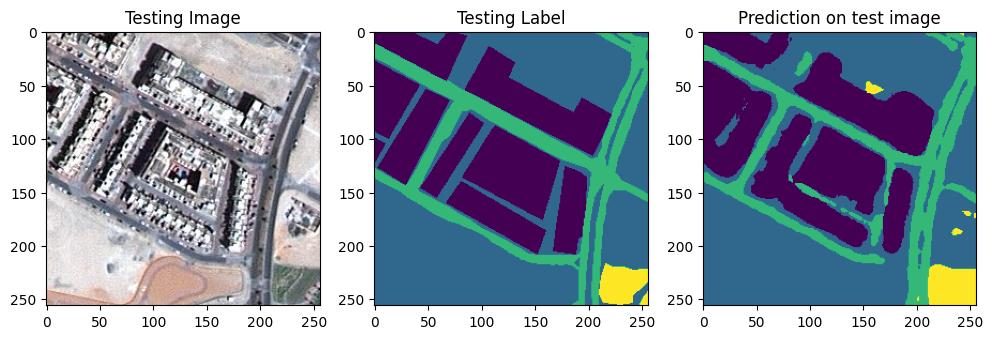

In [223]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [224]:
iou_scores = []

# Iterate over each image in X_test
for i in range(len(X_test)):
    # Predict segmentation mask for the image
    img = X_test[i]
    y_true = y_test_argmax[i]  # Access ground truth mask
    
    test_img_input = np.expand_dims(img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]
    
    
    # Compute IoU
    intersection = np.logical_and(predicted_img, y_true)
    union = np.logical_or(predicted_img, y_true)
    iou = np.sum(intersection) / np.sum(union)
    dict = {'idx':i,'image':img,'iou':iou,'y_true':y_true,'y_pred':predicted_img}
    
    # Append IoU score to the list
    iou_scores.append(dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [225]:

predict_df= pd.DataFrame(iou_scores)
iou_above_5= predict_df[(predict_df['iou'] >0.96 ) & (predict_df['iou'] < 1)]
iou_bellow_5 = predict_df.nsmallest(5,'iou')

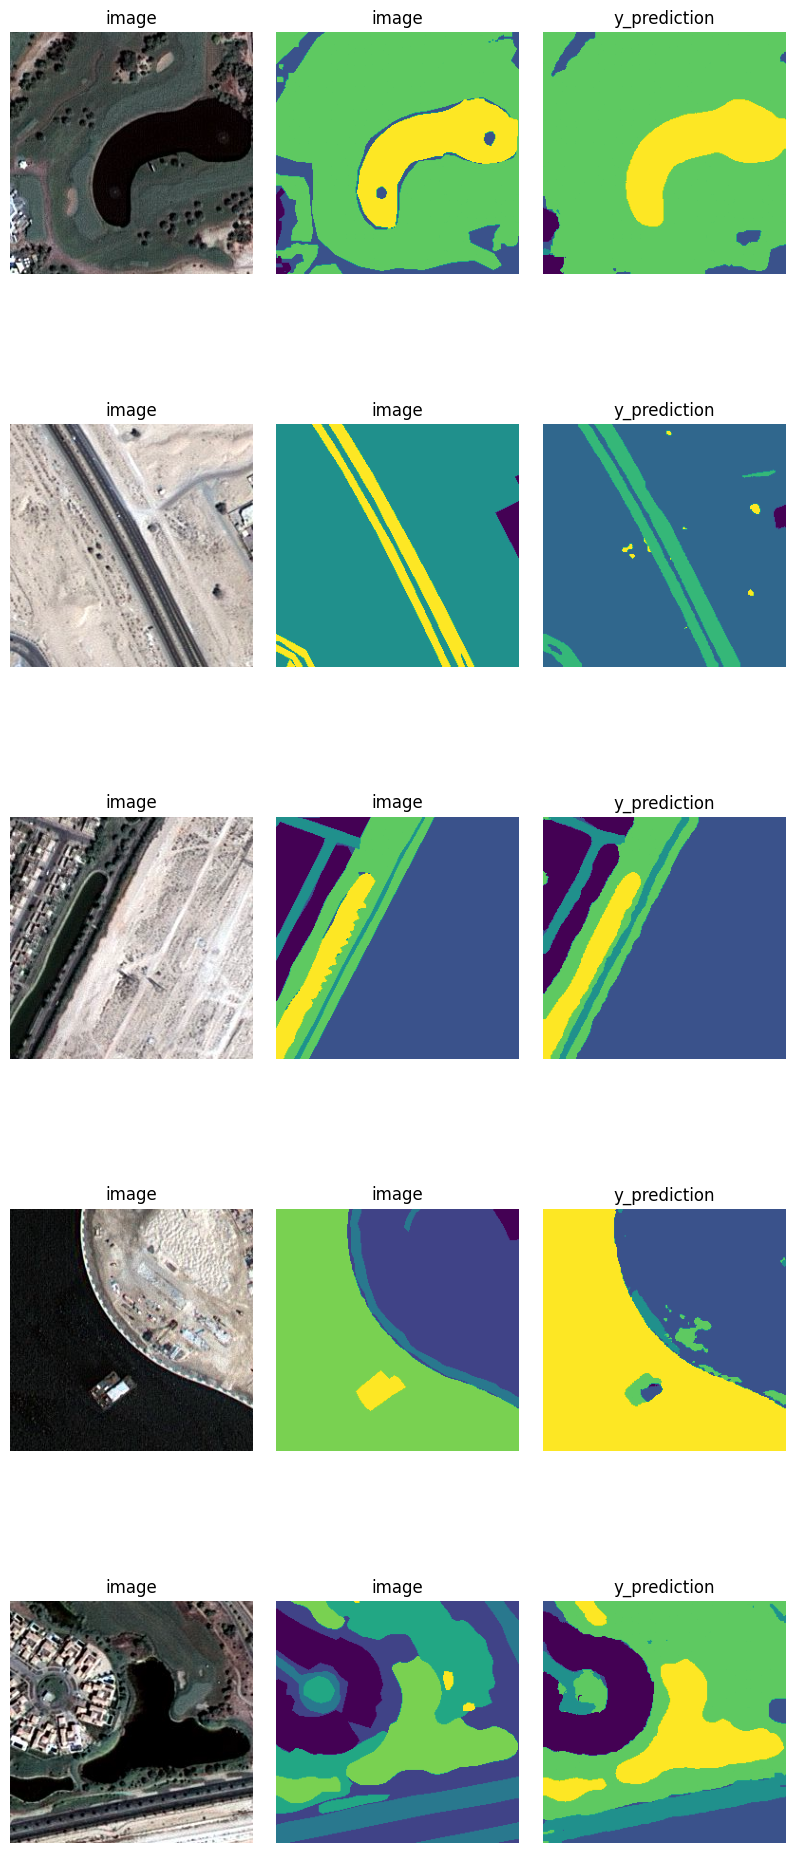

In [226]:
num_examples = 5
fig, axes = plt.subplots(num_examples, 3, figsize=(10, 5 * num_examples))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

for i in range(num_examples):
    axes[i, 0].imshow(iou_above_5['image'].iloc[i])
    axes[i, 0].set_title('image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(iou_above_5['y_true'].iloc[i])
    axes[i, 1].set_title('image')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(iou_above_5['y_pred'].iloc[i])
    axes[i, 2].set_title('y_prediction')
    axes[i, 2].axis('off')


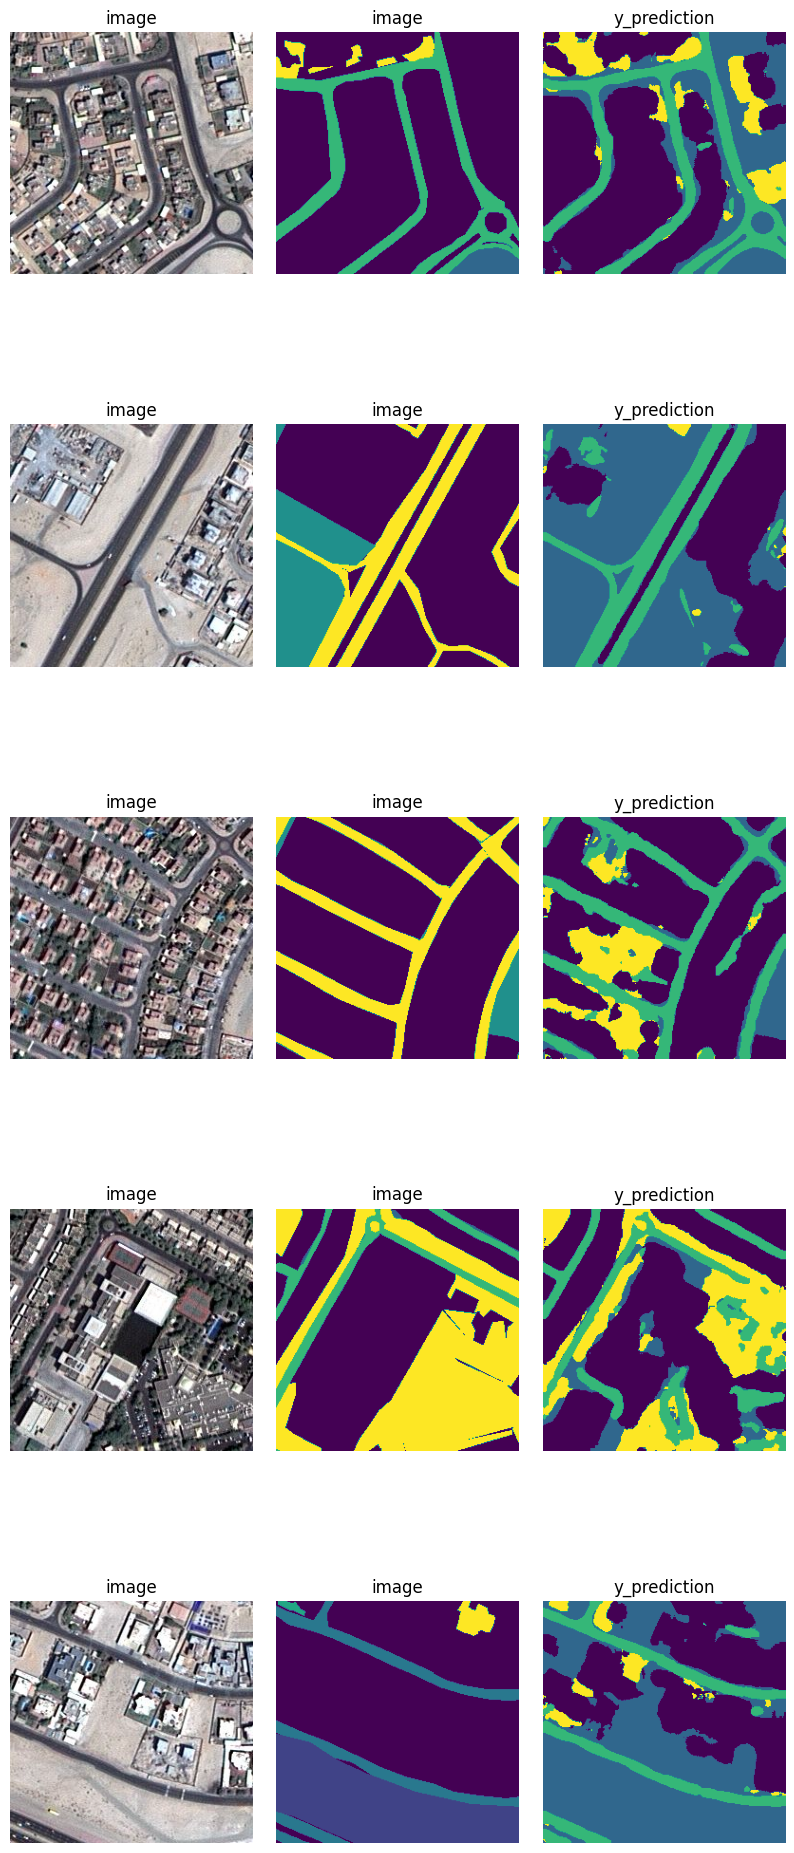

In [227]:
num_examples = 5
fig, axes = plt.subplots(num_examples, 3, figsize=(10, 5 * num_examples))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

for i in range(num_examples):
    axes[i, 0].imshow(iou_bellow_5['image'].iloc[i])
    axes[i, 0].set_title('image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(iou_bellow_5['y_true'].iloc[i])
    axes[i, 1].set_title('image')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(iou_bellow_5['y_pred'].iloc[i])
    axes[i, 2].set_title('y_prediction')
    axes[i, 2].axis('off')


## Evaluasi Hyperparameter

In [228]:
history_df=pd.read_excel(r'history_model_hyperparameter.xlsx')

In [229]:
import tensorflow as tf
from keras.models import load_model
from keras.metrics import MeanIoU

name = r'D:\belajar\final project\models\satellite_standard_unet_100epochs_22May2024.hdf5'
model = load_model(name,
                   custom_objects={'dice_loss_plus_2focal_loss': 'categorical_crossentropy',
                                   'jacard_coef': jacard_coef})

# Predict the labels for the test data
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Using built-in Keras function for IoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
iou_score = IOU_keras.result().numpy()


# Evaluate the model on the test data
metrics = model.evaluate(X_test, y_test, verbose=1)
loss = metrics[0]
accuracy = metrics[1]

# Calculate F1 score and recall
precision = Precision()
precision.update_state(y_test_argmax.flatten(), y_pred_argmax.flatten())
precision_result = precision.result().numpy()

recall = Recall()
recall.update_state(y_test_argmax.flatten(), y_pred_argmax.flatten())
recall_result = recall.result().numpy()

f1_score = 2 * (precision_result * recall_result) / (precision_result + recall_result)

print("Mean IoU =", iou_score)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Recall:", recall_result)


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8431 - jacard_coef: 0.6453 - loss: 0.4711
Mean IoU = 0.5593333
Loss: 0.48863890767097473
Accuracy: 0.8376047015190125
F1 Score: 0.959109744937408
Recall: 0.9539795


In [230]:
history_df

Unnamed: 0  accuracy  jacard_coef    loss  val_accuracy  val_jacard_coef  \
0            1    0.3946       0.2004  1.4730        0.6728           0.2798   
1            2    0.6601       0.3752  0.9608        0.7049           0.3876   
2            3    0.7076       0.4386  0.8255        0.7263           0.4252   
3            4    0.7235       0.4510  0.7995        0.7313           0.4324   
4            5    0.7400       0.4786  0.7416        0.7407           0.4618   
..         ...       ...          ...     ...           ...              ...   
95          96    0.8790       0.7012  0.3499        0.8608           0.6700   
96          97    0.8793       0.7016  0.3494        0.8607           0.6699   
97          98    0.8792       0.7014  0.3495        0.8604           0.6698   
98          99    0.8792       0.7015  0.3494        0.8604           0.6699   
99         100    0.8793       0.7016  0.3493        0.8606           0.6699   

    val_loss  
0     1.0553  
1     0.8540  
2     0.7691  
3     0.7401  
4     0.7183  
..       ...  
95    0.4178  
96    0.4179  
97    0.4180  
98    0.4179  
99    0.4179  

[100 rows x 7 columns]

Model hasil hyperparameter memiliki accuracy training 0.87 dan accuracy validasi 0.86. Berdasarkan accuracy model hyperparameter lebih baik dari sebelumnya, ini karna selisih dariaccuracy training dan validasi hanya 2%.

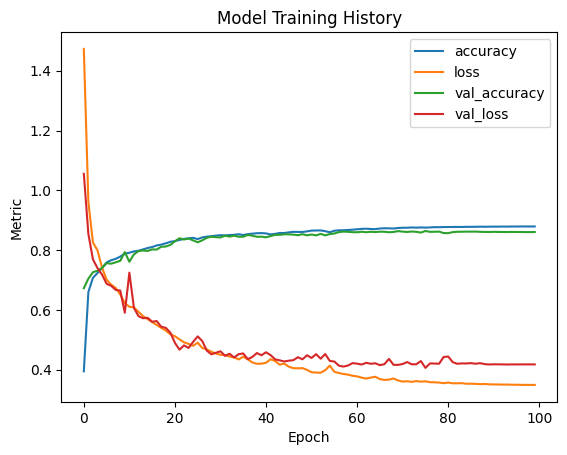

In [231]:
history_df[['accuracy','loss','val_accuracy','val_loss']].plot()
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

dilihat dari graphic, accuracy training dan testing cenderung konsisten mulai dari epoch 25. Loss training dan loss validation, loss training semakin mengecil ketika epoch makin tinggi sedangkan loss validation cenderung stuck nan mulai dari epoch 40.

In [232]:
import random
# test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


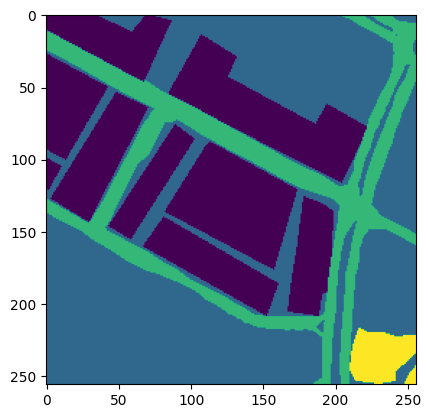

In [233]:
plt.imshow(ground_truth)

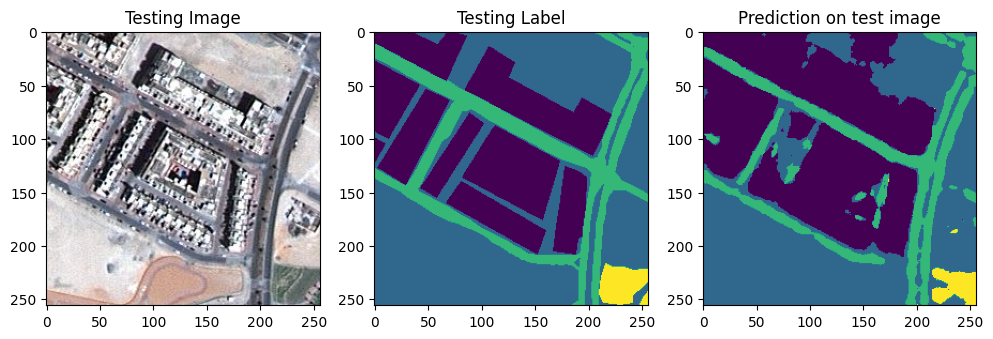

In [234]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [235]:
iou_scores = []

# Iterate over each image in X_test
for i in range(len(X_test)):
    # Predict segmentation mask for the image
    img = X_test[i]
    y_true = y_test_argmax[i]  # Access ground truth mask
    
    test_img_input = np.expand_dims(img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]
    
    
    # Compute IoU
    intersection = np.logical_and(predicted_img, y_true)
    union = np.logical_or(predicted_img, y_true)
    iou = np.sum(intersection) / np.sum(union)
    dict = {'idx':i,'image':img,'iou':iou,'y_true':y_true,'y_pred':predicted_img}
    
    # Append IoU score to the list
    iou_scores.append(dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━

In [236]:

predict_df= pd.DataFrame(iou_scores)
iou_above_5= predict_df[(predict_df['iou'] >0.96 ) & (predict_df['iou'] < 1)]
iou_bellow_5 = predict_df.nsmallest(5,'iou')

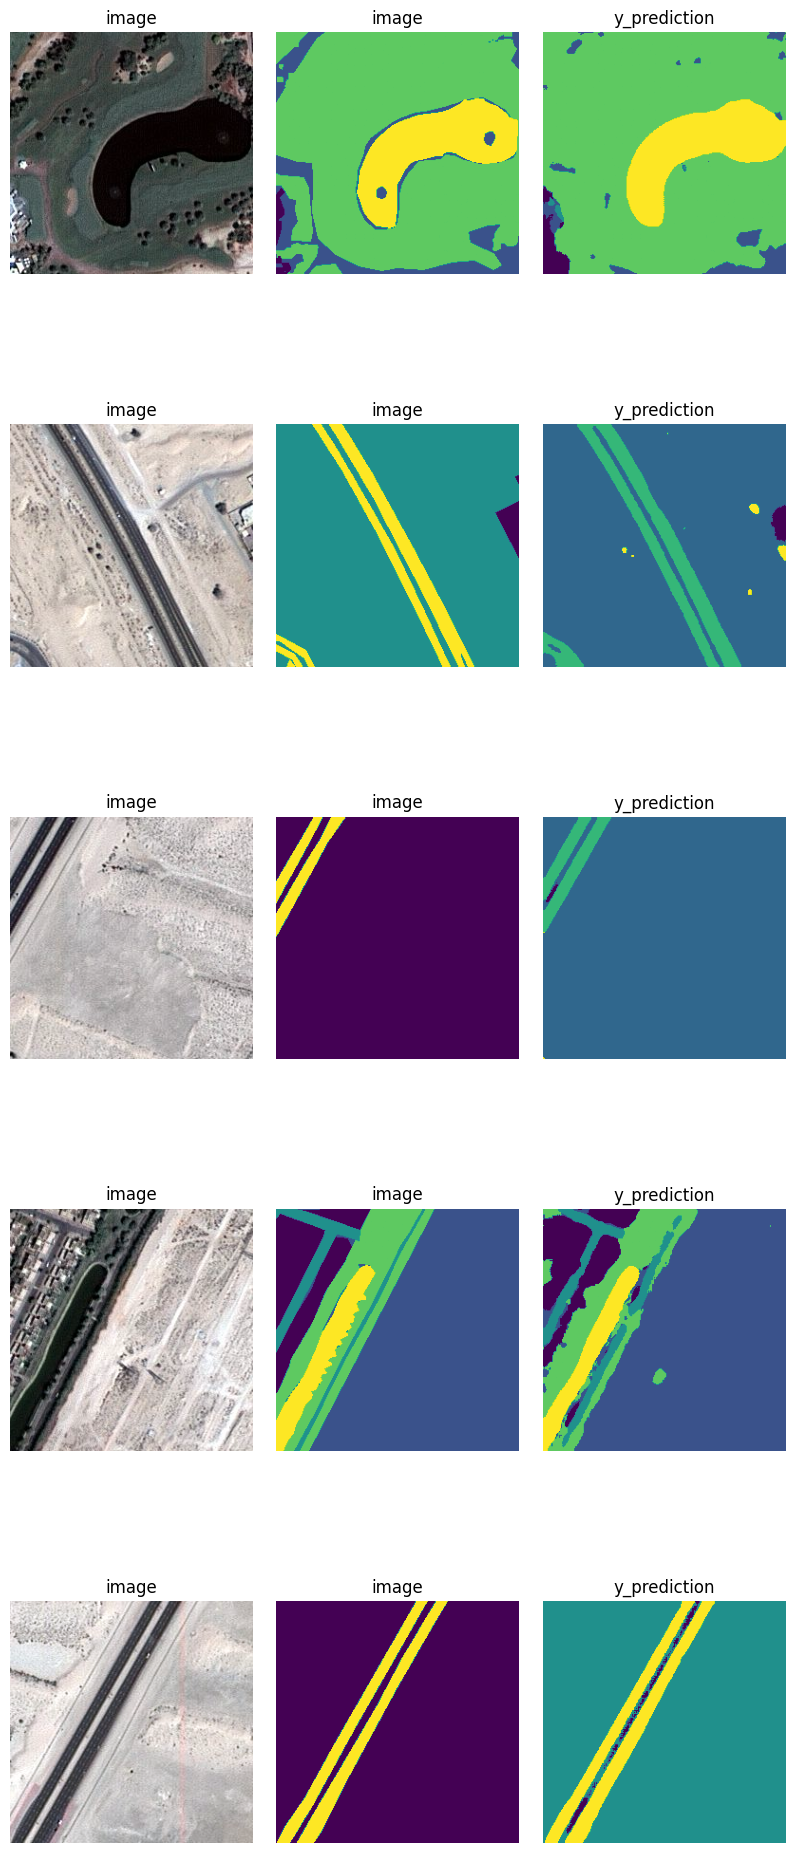

In [237]:
num_examples = 5
fig, axes = plt.subplots(num_examples, 3, figsize=(10, 5 * num_examples))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

for i in range(num_examples):
    axes[i, 0].imshow(iou_above_5['image'].iloc[i])
    axes[i, 0].set_title('image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(iou_above_5['y_true'].iloc[i])
    axes[i, 1].set_title('image')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(iou_above_5['y_pred'].iloc[i])
    axes[i, 2].set_title('y_prediction')
    axes[i, 2].axis('off')


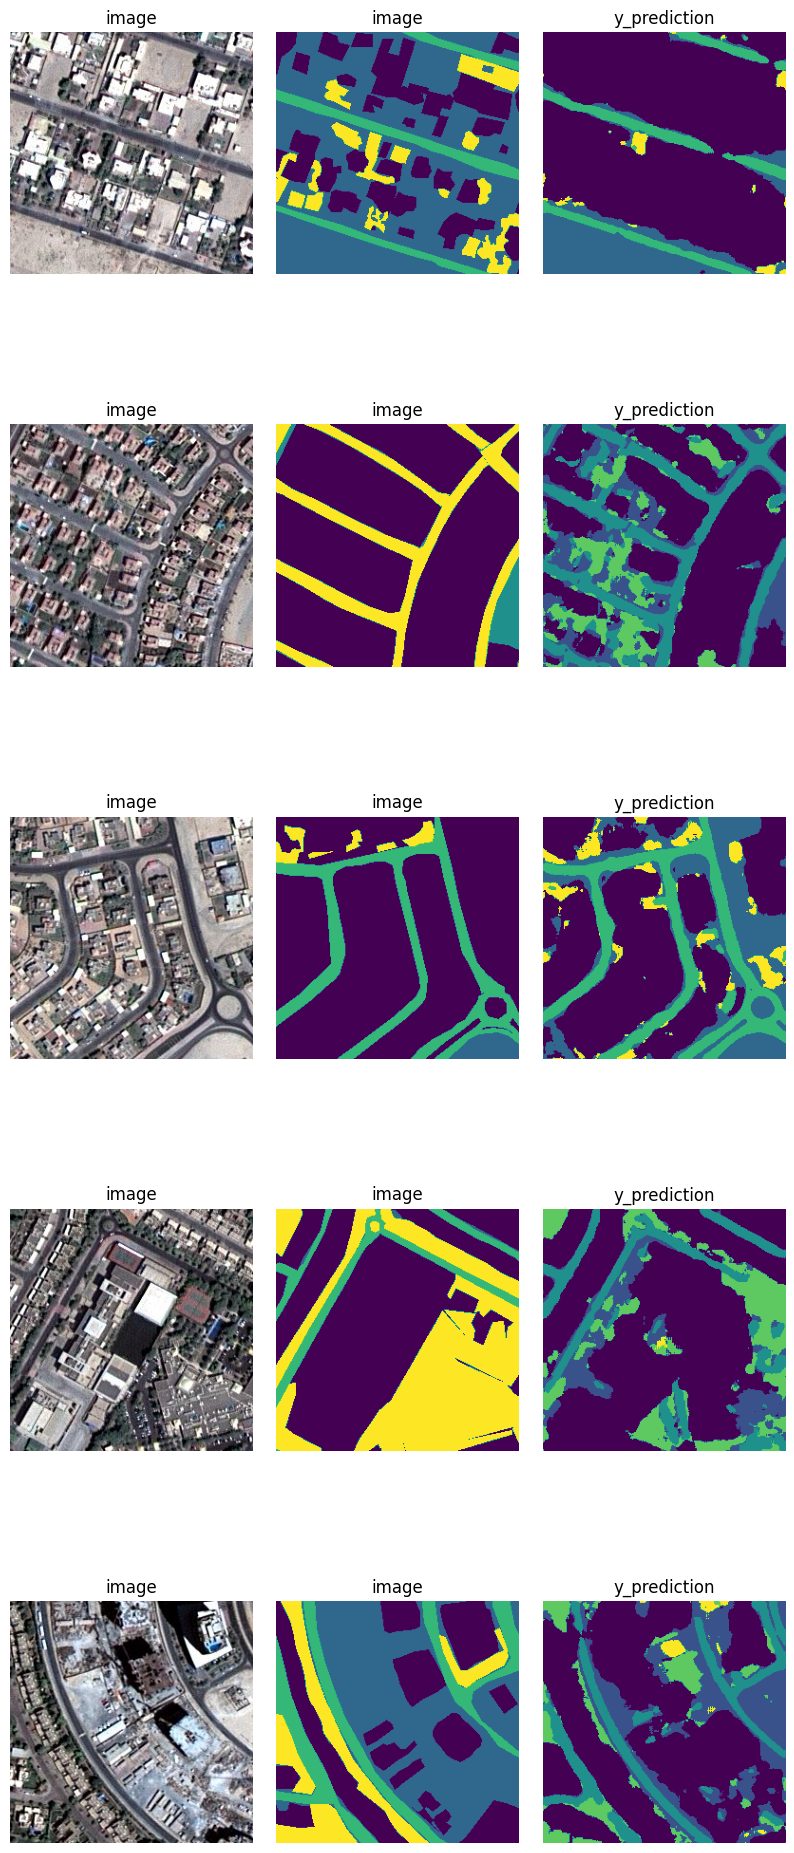

In [238]:
num_examples = 5
fig, axes = plt.subplots(num_examples, 3, figsize=(10, 5 * num_examples))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

for i in range(num_examples):
    axes[i, 0].imshow(iou_bellow_5['image'].iloc[i])
    axes[i, 0].set_title('image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(iou_bellow_5['y_true'].iloc[i])
    axes[i, 1].set_title('image')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(iou_bellow_5['y_pred'].iloc[i])
    axes[i, 2].set_title('y_prediction')
    axes[i, 2].axis('off')


Bedasarkan visual hasil prediksi sebelum dan sesudah hyperparameter, terlihat hasil prediksi yang sebelum lebih baik dibandingkan hasil setelah hyperparameter tuning, ini dapat dilihat dari hasil prediksi model sebelum dilakukan hyperparameter tuning memprediksi bagian-bagian bangunan dengan instance yang besar sehingga masih terlihat berbentuk bangunan, sedangkan hasil prediksi model setelah hyperparameter tuning memprediksi terlalu detail sehingga instance yang terbentuk tidak berbentuk bangunan. Dilihat dari angka IoU model sebelum dilakukan hyperparameter tuning juka lebih tinggi dibandingkan yang setelah. Sebelum hyperparameter tuning IoU 0.59 namun setelah hyperparameter tuning menjadi 0.55. Meskipun dari segi akurasi model lebih baik namun model hyperparameter tidak memprediksi lebih baik dibandingkan model sebelumnya.

B